In [79]:
# At the very top of your notebook
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import os
os.getcwd()


'/home/ankanguha/Desktop/Training/WEEK 6/ml-project/notebooks'

In [81]:
# Step 1: Add src folder to sys.path
import sys
import os

# Absolute path to src
src_path = "/home/ankanguha/Desktop/Training/WEEK 6/ml-project/src"
sys.path.append(src_path)
PROCESSED_PATH = "data/processed/bmw_final.csv"
# Step 2: Import functions from your pipeline
from pipelines.data_pipeline import load_data, clean_data, save_data
# Step 3: Test the functions
RAW_PATH = "../data/raw/bmw.csv"  # relative to notebooks folder

# Load and clean the data
df = load_data(RAW_PATH)
df_clean = clean_data(df)
save_data(df_clean, PROCESSED_PATH)
# Show top rows
df_clean.head()


2026-01-28 14:18:28,457 | INFO | Loading raw data from ../data/raw/bmw.csv
2026-01-28 14:18:28,467 | INFO | Data loaded with shape: (10781, 9)
2026-01-28 14:18:28,468 | INFO | Starting cleaning process...
2026-01-28 14:18:28,473 | INFO | Dropped 117 duplicate rows
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/src/pipelines/data_pipeline.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/src/pipelines/data_pipeline.py:37: SettingW

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200.0,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000.0,Automatic,14827,Petrol,145,42.8,2.0
5,5 Series,2016,14900.0,Automatic,35309,Diesel,125,60.1,2.0
6,5 Series,2017,16000.0,Automatic,38538,Diesel,125,60.1,2.0
10,X3,2017,15500.0,Manual,74907,Diesel,145,52.3,2.0


In [82]:
processed_path = "../data/processed/bmw_final.csv"
df_clean.to_csv(processed_path, index=False)
print(f"Cleaned dataset saved to {processed_path}")


Cleaned dataset saved to ../data/processed/bmw_final.csv


In [83]:
import sys
from pathlib import Path

import pandas as pd
# project root (ml-project)
PROJECT_ROOT = Path.cwd().parent

# add src to path
sys.path.append(str(PROJECT_ROOT / "src"))


In [84]:
from features.build_features import build_features
from sklearn.model_selection import train_test_split
X, y, z = build_features(df_clean)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
z

LabelEncoder()

In [90]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(3780, 18) (946, 18)
(3780,) (946,)


In [91]:
import numpy as np
import pandas as pd
from features.feature_selector import remove_highly_correlated_features
X_train_df = pd.DataFrame(X_train)

# Select numeric columns only
X_train_num = X_train_df.select_dtypes(include=np.number)

X_train_corr, X_dropped=remove_highly_correlated_features(X_train_num, 0.85)
X_test_corr = X_test[X_train_corr.columns]

print(X_train_corr.shape)

Dropped due to correlation > 0.85: ['car_age', 'mileage_per_year', 'log_tax', 'mpg_per_engine', 'tax_per_engine']
(3780, 9)


In [92]:

from features.feature_selector import select_features_mutual_info

selected_features, mi_df = select_features_mutual_info(X_train_corr, y_train)
mi_df

,feature,mi_score
1,year,0.689090
2,mileage,0.607546
6,log_mileage,0.593840
4,mpg,0.431492
0,model,0.255837
3,tax,0.218984
7,is_automatic,0.053017
8,is_diesel,0.037185
5,engineSize,0.000000


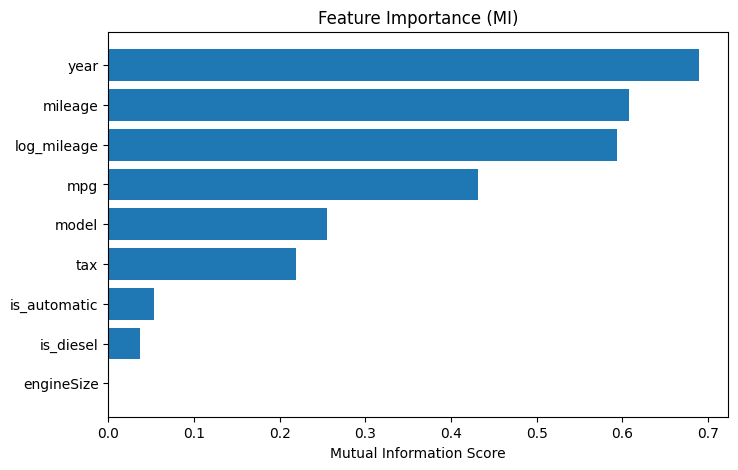

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(mi_df["feature"], mi_df["mi_score"])
plt.xlabel("Mutual Information Score")
plt.title("Feature Importance (MI)")
plt.gca().invert_yaxis()
plt.show()


In [94]:
X_train_mi = X_train_corr[selected_features]
X_test_mi = X_test_corr[selected_features]

print(X_train_mi.shape, X_test_mi.shape)

(3780, 8) (946, 8)


In [95]:
from features.feature_selector import select_features_rfe

selected_rfe_features = select_features_rfe(X_train_mi, y_train)
print(selected_rfe_features)


Index(['year', 'log_mileage', 'model', 'is_automatic', 'is_diesel'], dtype='object')


In [96]:
X_train_final = X_train_mi[selected_rfe_features]
X_test_final = X_test_mi[selected_rfe_features]

X_train_final.shape, X_test_final.shape
X_train_final

,year,log_mileage,model,is_automatic,is_diesel
2850,2017,10.684623,2,0,1
6145,2019,8.547916,2,0,1
3314,2020,4.663439,2,0,1
604,2017,9.957313,2,0,0
2000,2018,9.873492,2,0,1
...,...,...,...,...,...
9870,2014,10.203629,2,0,1
1038,2013,11.012248,4,0,1
6105,2020,1.791759,11,0,0
7595,2016,10.819798,8,1,1


In [97]:
from training.train import train_all_models

models, best_model, metrics = train_all_models(
    X_train_final, X_test_final, y_train, y_test
)
import json
print(json.dumps(metrics, indent=4))


/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


LinearRegression: Test R2=0.7375, 5-Fold CV R2=0.7322
RandomForest: Test R2=0.8322, 5-Fold CV R2=0.8139
XGBoost: Test R2=0.8363, 5-Fold CV R2=0.8013


/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Opti

NeuralNetwork: Test R2=0.4431, 5-Fold CV R2=0.4397
Best model: XGBoost with R2=0.8363
All models and metrics saved.
{
    "LinearRegression": {
        "MAE": 2733.292351914868,
        "RMSE": 3499.8029938008267,
        "R2": 0.7374567107245037,
        "CV_R2_mean": 0.7322405030879707
    },
    "RandomForest": {
        "MAE": 2034.6579957665367,
        "RMSE": 2798.1390592983385,
        "R2": 0.8321766781793519,
        "CV_R2_mean": 0.8139393614826365
    },
    "XGBoost": {
        "MAE": 2040.9324773098904,
        "RMSE": 2763.336948279219,
        "R2": 0.8363253528657254,
        "CV_R2_mean": 0.8012856096481329
    },
    "NeuralNetwork": {
        "MAE": 4083.889350756029,
        "RMSE": 5097.017523662081,
        "R2": 0.44314005677337054,
        "CV_R2_mean": 0.4396546108101367
    }
}


/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [98]:
from training.tuning import tune_xgboost

best_model_tuned, results = tune_xgboost(X_train_final, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
✅ Hyperparameter tuning completed!
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV R2: 0.8443


In [99]:
from training.tuning2 import tune_xgboost_optuna

best_model_tuned, results = tune_xgboost_optuna(X_train_final, y_train, n_trials=30)


[I 2026-01-28 14:19:15,583] A new study created in memory with name: no-name-4a96eb8c-a6d1-4dbe-9189-f45559e4db0d
[I 2026-01-28 14:19:15,887] Trial 0 finished with value: 0.8426572934050196 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.27885997363504145, 'subsample': 0.87324027962809, 'colsample_bytree': 0.7651571747785955}. Best is trial 0 with value: 0.8426572934050196.
[I 2026-01-28 14:19:16,692] Trial 1 finished with value: 0.8266044302234636 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.01175829434204693, 'subsample': 0.6272034305746255, 'colsample_bytree': 0.7887966304697419}. Best is trial 0 with value: 0.8426572934050196.
[I 2026-01-28 14:19:18,171] Trial 2 finished with value: 0.8121168048831574 and parameters: {'n_estimators': 220, 'max_depth': 4, 'learning_rate': 0.011210413159442748, 'subsample': 0.6082418159175675, 'colsample_bytree': 0.6324053633088192}. Best is trial 0 with value: 0.8426572934050196.
[I 2026-01-28 14:

✅ Optuna hyperparameter tuning completed!
Best parameters: {'n_estimators': 228, 'max_depth': 6, 'learning_rate': 0.02312380742241141, 'subsample': 0.7284236598020554, 'colsample_bytree': 0.9524900873310866}
Best CV R2: 0.8470


In [13]:
from evaluation.shap_analysis import run_shap_analysis
run_shap_analysis(X_train_final)



 99%|===================| 3758/3780 [00:39<00:00]        

SHAP analysis completed


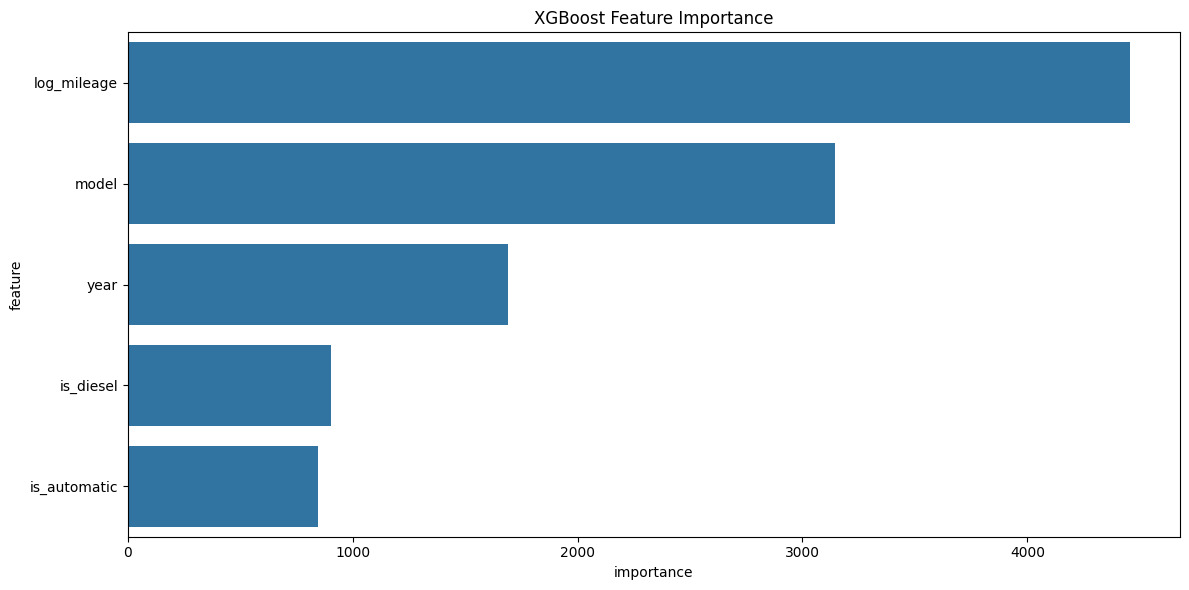

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load model
model = joblib.load(MODELS_DIR / "xgb_tuned_optuna.pkl")
booster = model.get_booster()

# Get feature importances (weight, gain, cover)
importance_dict = booster.get_score(importance_type='weight')  # or 'gain' for more meaningful importance

# Convert to DataFrame
feat_imp_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


In [101]:
# 1️⃣ Check column data types
print("Column dtypes:\n")
print(X_train.dtypes)
print("Column dtypes:\n")
print(X_test.dtypes)

# 2️⃣ See which columns are still object
obj_cols = X_test.select_dtypes(include='object').columns
print("\nColumns with object dtype:", list(obj_cols))

# 3️⃣ Check unique values in object columns
for col in obj_cols:
    print(f"\nColumn: {col}")
    print(X_test[col].unique())

# 4️⃣ Check for NaNs in all columns
print("\nNaNs per column:\n", X_test.isna().sum())


Column dtypes:

model                       int64
year                        int64
mileage                     int64
tax                         int64
mpg                       float64
engineSize                float64
car_age                     int64
mileage_per_year          float64
log_mileage               float64
log_tax                   float64
mpg_per_engine            float64
tax_per_engine            float64
is_automatic                int64
is_diesel                   int64
transmission_Manual          bool
transmission_Semi-Auto       bool
fuelType_Hybrid              bool
fuelType_Petrol              bool
dtype: object
Column dtypes:

model                       int64
year                        int64
mileage                     int64
tax                         int64
mpg                       float64
engineSize                float64
car_age                     int64
mileage_per_year          float64
log_mileage               float64
log_tax                   float64
mp

In [ ]:

X_test_old = X_test[['year', 'log_mileage', 'model', 'is_automatic', 'is_diesel']]

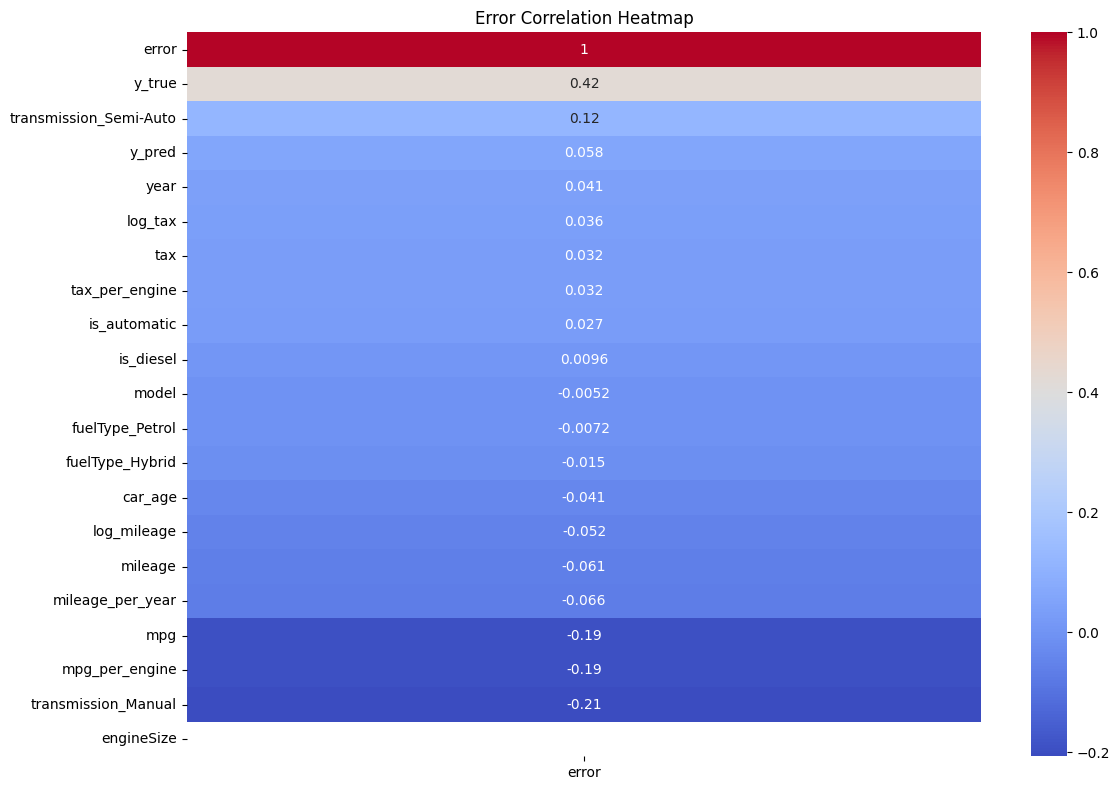

High-error rows (top 10%):
      model  year  mileage  tax   mpg  engineSize  car_age  mileage_per_year  \
5577      7  2020      700  145  34.0         2.0        5        140.000000   
2418      6  2019     5234  145  68.9         2.0        6        872.333333   
5678      2  2020     2475  145  40.4         2.0        5        495.000000   
4413      2  2019     7258  145  49.6         2.0        6       1209.666667   
2422      4  2019      101  145  50.4         2.0        6         16.833333   
...     ...   ...      ...  ...   ...         ...      ...               ...   
5700      3  2020     2986  150  65.7         2.0        5        597.200000   
3652      4  2019     9165  145  50.4         2.0        6       1527.500000   
1668      1  2020      600  145  36.2         2.0        5        120.000000   
2242      2  2020       18  145  56.5         2.0        5          3.600000   
1883      0  2019     8211  145  34.5         2.0        6       1368.500000   

      log_mi

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1️⃣ Predict
y_pred = model.predict(X_test_old)

# 2️⃣ Compute errors (regression example)
errors = y_test - y_pred

# 3️⃣ Prepare DataFrame
X_test_df = X_test.copy()  # Ensure X_test is a DataFrame
X_test_df['error'] = errors
X_test_df['y_true'] = y_test
X_test_df['y_pred'] = y_pred

# 4️⃣ Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(X_test_df.corr()[['error']].sort_values(by='error', ascending=False), annot=True, cmap='coolwarm')
plt.title("Error Correlation Heatmap")
plt.tight_layout()
plt.show()

# 5️⃣ Optional: high-error rows
threshold = errors.abs().quantile(0.9)  # top 10% errors
high_error_rows = X_test_df[errors.abs() > threshold]
print("High-error rows (top 10%):")
print(high_error_rows)
